# MadMiner particle physics tutorial

# Appendix 1: Adding systematic uncertainties

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In this tutorial we'll explain how to add systematic uncertainties to the MadMiner workflow. Note that the treatment of systematic uncertainties changed substantially with `MadMiner v0.6`, including changes to the MadMiner file specification. Please don't use files from older MadMiner versions with systematic uncertainties.

## Preparations

Before you execute this notebook, make sure you have running installations of MadGraph, Pythia, and Delphes.

In [36]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.core import MadMiner
from madminer.lhe import LHEReader
from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import ScoreEstimator
from madminer.fisherinformation import FisherInformation, profile_information, project_information
from madminer.plotting import plot_systematics, plot_fisher_information_contours_2d


Please enter here the path to your MG5 root directory.

In [2]:
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_4'

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [3]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Parameters and benchmarks

We'll just load the MadMiner setup from the first part of this tutorial:

In [4]:
miner = MadMiner()
miner.load('data/setup.h5')

15:34 madminer.core        INFO    Found 2 parameters:
15:34 madminer.core        INFO       CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
15:34 madminer.core        INFO       CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-20.0, 20.0))
15:34 madminer.core        INFO    Found 6 benchmarks:
15:34 madminer.core        INFO       sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:34 madminer.core        INFO       w: CWL2 = 15.20, CPWL2 = 0.10
15:34 madminer.core        INFO       neg_w: CWL2 = -1.54e+01, CPWL2 = 0.20
15:34 madminer.core        INFO       ww: CWL2 = 0.30, CPWL2 = 15.10
15:34 madminer.core        INFO       neg_ww: CWL2 = 0.40, CPWL2 = -1.53e+01
15:34 madminer.core        INFO       morphing_basis_vector_5: CWL2 = -1.68e+01, CPWL2 = -1.72e+01
15:34 madminer.core        INFO    Found morphing setup with 6 components
15:34 madminer.core        INFO    Did not find systematics setup.


## 2. Set up systematics, save settings

This is where things become interesting: We want to model systematic uncertainties. The main function is `add_systematics()`, the keyword `effect` determines how the effect of the nuisance parameters on the event weights is calculated. For `effect="norm"`, the nuisance parameter rescales thee overall cross section of one or multiple samples. For `effect="pdf"`, its effect is calculated with PDF variations. Finally, with `effect="scale"` scale variations are used.

Here we consider three nuisance parameters: one for the signal normalization, one for the background normalization, and one for scale uncertainties (which we here assume to be correlated between signal and background).

In [6]:
miner.add_systematics(effect="norm", systematic_name="signal_norm", norm_variation=1.1)
miner.add_systematics(effect="norm", systematic_name="bkg_norm", norm_variation=1.2)
miner.add_systematics(effect="scale", systematic_name="scales", scale="mu")

Again, we save our setup:

In [7]:
miner.save('data/setup_systematics.h5')

15:34 madminer.core        INFO    Saving setup (including morphing) to data/setup_systematics.h5


## 3. Run MadGraph

Now it's time to run MadGraph. MadMiner will instruct MadGraph to use its built-in `systematics` tool to calculate how the event weights change under the scale variation.

In [10]:
miner.run(
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/signal_systematics',
    proc_card_file='cards/proc_card_signal.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_file='cards/run_card_signal_small.dat',
    log_directory='logs/signal',
    python2_override=True,
    systematics=["signal_norm", "scales"],
)

15:43 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_signal.dat at ./mg_processes/signal_systematics
15:43 madminer.core        INFO    Run 0
15:43 madminer.core        INFO      Sampling from benchmark: sm
15:43 madminer.core        INFO      Original run card:       cards/run_card_signal_small.dat
15:43 madminer.core        INFO      Original Pythia8 card:   None
15:43 madminer.core        INFO      Copied run card:         /madminer/cards/run_card_0.dat
15:43 madminer.core        INFO      Copied Pythia8 card:     None
15:43 madminer.core        INFO      Param card:              /madminer/cards/param_card_0.dat
15:43 madminer.core        INFO      Reweight card:           /madminer/cards/reweight_card_0.dat
15:43 madminer.core        INFO      Log file:                run_0.log
15:43 madminer.core        INFO    Creating param and reweight cards in ./mg_processes/signal_systematics//madminer/cards/param_card_0.dat, ./mg_processes/signal_systema

In [11]:
miner.run(
    sample_benchmark='sm',
    mg_directory=mg_dir,
    mg_process_directory='./mg_processes/bkg_systematics',
    proc_card_file='cards/proc_card_background.dat',
    param_card_template_file='cards/param_card_template.dat',
    run_card_file='cards/run_card_background.dat',
    log_directory='logs/background',
    python2_override=True,
    systematics=["bkg_norm", "scales"],
)

15:49 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_background.dat at ./mg_processes/bkg_systematics
15:49 madminer.core        INFO    Run 0
15:49 madminer.core        INFO      Sampling from benchmark: sm
15:49 madminer.core        INFO      Original run card:       cards/run_card_background.dat
15:49 madminer.core        INFO      Original Pythia8 card:   None
15:49 madminer.core        INFO      Copied run card:         /madminer/cards/run_card_0.dat
15:49 madminer.core        INFO      Copied Pythia8 card:     None
15:49 madminer.core        INFO      Param card:              /madminer/cards/param_card_0.dat
15:49 madminer.core        INFO      Reweight card:           /madminer/cards/reweight_card_0.dat
15:49 madminer.core        INFO      Log file:                run_0.log
15:49 madminer.core        INFO    Creating param and reweight cards in ./mg_processes/bkg_systematics//madminer/cards/param_card_0.dat, ./mg_processes/bkg_systematics//m

## 4. Load events from LHE file

When adding LHE or Delphes files, use the `systematics` keyword to list which systematic uncertainties apply to which sample:

In [4]:
lhe = LHEReader('data/setup_systematics.h5')

lhe.add_sample(
    lhe_filename='mg_processes/signal_systematics/Events/run_01/unweighted_events.lhe.gz',
    sampled_from_benchmark='sm',
    is_background=False,
    k_factor=1.1,
    systematics=["signal_norm", "scales"]
)

lhe.add_sample(
    lhe_filename='mg_processes/bkg_systematics/Events/run_01/unweighted_events.lhe.gz',
    sampled_from_benchmark='sm',
    is_background=True,
    k_factor=1.1,
    systematics=["bkg_norm", "scales"]
)

11:11 madminer.utils.inter DEBUG   HDF5 file does not contain is_reference field.
11:11 madminer.lhe         DEBUG   Adding event sample mg_processes/signal_systematics/Events/run_01/unweighted_events.lhe.gz
11:11 madminer.lhe         DEBUG   Adding event sample mg_processes/bkg_systematics/Events/run_01/unweighted_events.lhe.gz


The next steps are unaffected by systematics.

In [5]:
lhe.set_smearing(
    pdgids=[1,2,3,4,5,6,9,21,-1,-2,-3,-4,-5,-6],   # Partons giving rise to jets
    energy_resolution_abs=0.,
    energy_resolution_rel=0.1,
    pt_resolution_abs=None,
    pt_resolution_rel=None,
    eta_resolution_abs=0.1,
    eta_resolution_rel=0.,
    phi_resolution_abs=0.1,
    phi_resolution_rel=0.,
)

lhe.add_observable(
    'pt_j1',
    'j[0].pt',
    required=False,
    default=0.,
)
lhe.add_observable(
    'delta_phi_jj',
    'j[0].deltaphi(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta))',
    required=True,
)
lhe.add_observable(
    'met',
    'met.pt',
    required=True,
)

lhe.add_cut('(a[0] + a[1]).m > 122.')
lhe.add_cut('(a[0] + a[1]).m < 128.')
lhe.add_cut('pt_j1 > 30.')

11:11 madminer.lhe         DEBUG   Adding optional observable pt_j1 = j[0].pt with default 0.0
11:11 madminer.lhe         DEBUG   Adding required observable delta_phi_jj = j[0].deltaphi(j[1]) * (-1. + 2.*float(j[0].eta > j[1].eta))
11:11 madminer.lhe         DEBUG   Adding required observable met = met.pt
11:11 madminer.lhe         DEBUG   Adding cut (a[0] + a[1]).m > 122.
11:11 madminer.lhe         DEBUG   Adding cut (a[0] + a[1]).m < 128.
11:11 madminer.lhe         DEBUG   Adding cut pt_j1 > 30.


In [6]:
lhe.analyse_samples()
lhe.save('data/lhe_data_systematics.h5')

11:11 madminer.lhe         INFO    Analysing LHE sample mg_processes/signal_systematics/Events/run_01/unweighted_events.lhe.gz: Calculating 3 observables, requiring 3 selection cuts, using 0 efficiency factors, associated with systematics signal_norm, scales
11:11 madminer.lhe         DEBUG   Extracting nuisance parameter definitions from LHE file
11:11 madminer.utils.inter DEBUG   Parsing nuisance parameter setup from LHE file at mg_processes/signal_systematics/Events/run_01/unweighted_events.lhe.gz
11:11 madminer.utils.inter DEBUG   Systematics setup: OrderedDict([(u'signal_norm', (u'norm', 1.1)), (u'scales', (u'scale', 'mu', '0.5,1.0,2.0'))])
11:11 madminer.utils.inter DEBUG   3 weight groups
11:11 madminer.utils.inter DEBUG   Extracting nuisance parameter information for systematic signal_norm
11:11 madminer.utils.inter DEBUG   Extracting nuisance parameter information for systematic scales
11:11 madminer.utils.inter DEBUG   New weight group: Central scale variation
11:11 madminer.

11:12 madminer.utils.inter DEBUG   Parsing LHE file mg_processes/bkg_systematics/Events/run_01/unweighted_events.lhe.gz
11:12 madminer.utils.inter DEBUG   Parsing header and events as XML with cElementTree
11:12 madminer.utils.inter DEBUG   Found entry event_norm = sum in LHE header. Interpreting this as weight_norm_is_average = False.
11:12 madminer.utils.inter DEBUG   Event 1 passes observations, passes cuts, passes efficiencies -> passes
11:12 madminer.utils.inter DEBUG   Event 2 passes observations, passes cuts, passes efficiencies -> passes
11:12 madminer.utils.inter DEBUG   Event 3 passes observations, passes cuts, passes efficiencies -> passes
11:12 madminer.utils.inter DEBUG   Event 4 passes observations, passes cuts, passes efficiencies -> passes
11:12 madminer.utils.inter DEBUG   Event 5 passes observations, passes cuts, passes efficiencies -> passes
11:12 madminer.utils.inter DEBUG   Event 6 passes observations, passes cuts, passes efficiencies -> passes
11:12 madminer.utils

### A look at distributions

The function `plot_systematics()` makes it easy to check the effect of the various nuisance parameters on a distribution:

In [6]:
plot_systematics?

11:23 madminer.analysis    INFO    Loading data from data/lhe_data_systematics.h5
11:23 madminer.analysis    INFO    Found 2 parameters
11:23 madminer.analysis    DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
11:23 madminer.analysis    DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-20.0, 20.0))
11:23 madminer.analysis    INFO    Found 3 nuisance parameters
11:23 madminer.analysis    DEBUG      signal_norm_nuisance_param_0 ((u'signal_norm', u'signal_norm_nuisance_param_0_benchmark_0', None))
11:23 madminer.analysis    DEBUG      scales_nuisance_param_0 ((u'scales', u'scales_nuisance_param_0_benchmark_0', u'scales_nuisance_param_0_benchmark_1'))
11:23 madminer.analysis    DEBUG      bkg_norm_nuisance_param_0 ((u'bkg_norm', u'bkg_norm_nuisance_param_0_benchmark_0', None))
11:23 madminer.analysis    INFO    Found 10 benchmarks, of which 6 physical
11:23 madminer.analysis    DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00

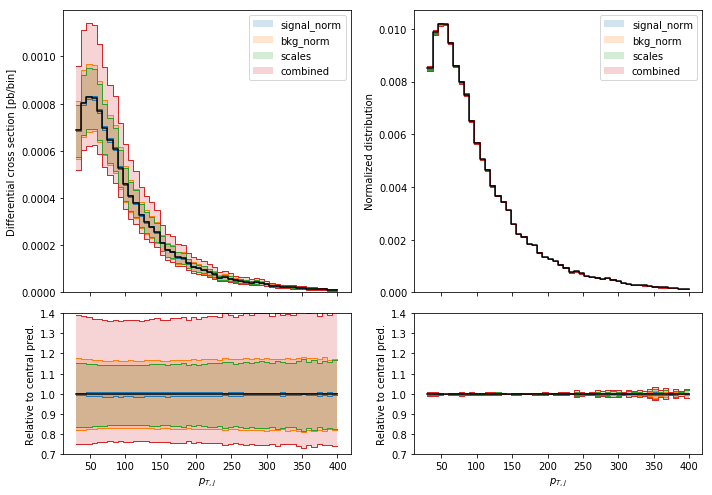

In [5]:
_ = plot_systematics(
    filename='data/lhe_data_systematics.h5',
    theta=np.array([0.,0.]),
    observable="pt_j1",
    obs_label="$p_{T,j}$",
    obs_range=(30.,400.),
    ratio_range=(0.7,1.4)
)

11:24 madminer.analysis    INFO    Loading data from data/lhe_data_systematics.h5
11:24 madminer.analysis    INFO    Found 2 parameters
11:24 madminer.analysis    DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
11:24 madminer.analysis    DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-20.0, 20.0))
11:24 madminer.analysis    INFO    Found 3 nuisance parameters
11:24 madminer.analysis    DEBUG      signal_norm_nuisance_param_0 ((u'signal_norm', u'signal_norm_nuisance_param_0_benchmark_0', None))
11:24 madminer.analysis    DEBUG      scales_nuisance_param_0 ((u'scales', u'scales_nuisance_param_0_benchmark_0', u'scales_nuisance_param_0_benchmark_1'))
11:24 madminer.analysis    DEBUG      bkg_norm_nuisance_param_0 ((u'bkg_norm', u'bkg_norm_nuisance_param_0_benchmark_0', None))
11:24 madminer.analysis    INFO    Found 10 benchmarks, of which 6 physical
11:24 madminer.analysis    DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00

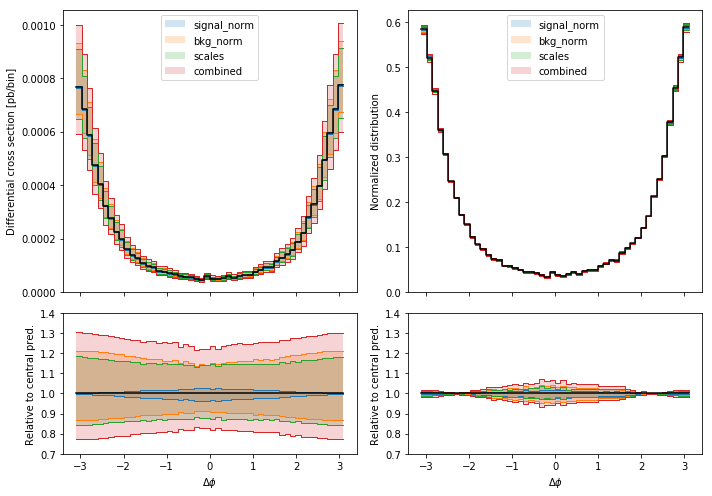

In [6]:
_ = plot_systematics(
    filename='data/lhe_data_systematics.h5',
    theta=np.array([0.,0.]),
    observable="delta_phi_jj",
    obs_label=r"$\Delta\phi$",
    obs_range=(-3.1,3.1),
    ratio_range=(0.7,1.4)
)

## 5. Sampling

Let's generate training data for the SALLY method.

In [7]:
sampler = SampleAugmenter('data/lhe_data_systematics.h5', include_nuisance_parameters=True)

x, theta, t_xz, _ = sampler.sample_train_local(
    theta=sampling.benchmark('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train_score_systematics'
)

11:27 madminer.analysis    INFO    Loading data from data/lhe_data_systematics.h5
11:27 madminer.analysis    INFO    Found 2 parameters
11:27 madminer.analysis    DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
11:27 madminer.analysis    DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-20.0, 20.0))
11:27 madminer.analysis    INFO    Found 3 nuisance parameters
11:27 madminer.analysis    DEBUG      signal_norm_nuisance_param_0 ((u'signal_norm', u'signal_norm_nuisance_param_0_benchmark_0', None))
11:27 madminer.analysis    DEBUG      scales_nuisance_param_0 ((u'scales', u'scales_nuisance_param_0_benchmark_0', u'scales_nuisance_param_0_benchmark_1'))
11:27 madminer.analysis    DEBUG      bkg_norm_nuisance_param_0 ((u'bkg_norm', u'bkg_norm_nuisance_param_0_benchmark_0', None))
11:27 madminer.analysis    INFO    Found 10 benchmarks, of which 6 physical
11:27 madminer.analysis    DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00

## 6. Training

The SALLY estimator will learn the score in terms of both the physics parameters and the nuisance parameters. In our case, its output will therefore be a vector with five components.

In [10]:
estimator = ScoreEstimator(n_hidden=(50,))

estimator.train(
    method='sally',
    x='data/samples/x_train_score_systematics.npy',
    t_xz='data/samples/t_xz_train_score_systematics.npy',
)

estimator.save('models/sally_systematics')

11:29 madminer.ml          INFO    Starting training
11:29 madminer.ml          INFO      Batch size:             128
11:29 madminer.ml          INFO      Optimizer:              amsgrad
11:29 madminer.ml          INFO      Epochs:                 50
11:29 madminer.ml          INFO      Learning rate:          0.001 initially, decaying to 0.0001
11:29 madminer.ml          INFO      Validation split:       0.25
11:29 madminer.ml          INFO      Early stopping:         True
11:29 madminer.ml          INFO      Scale inputs:           True
11:29 madminer.ml          INFO      Shuffle labels          False
11:29 madminer.ml          INFO      Samples:                all
11:29 madminer.ml          INFO    Loading training data
11:29 madminer.utils.vario INFO      Loading data/samples/x_train_score_systematics.npy into RAM
11:29 madminer.utils.vario INFO      Loading data/samples/t_xz_train_score_systematics.npy into RAM
11:29 madminer.ml          INFO    Found 100000 samples with 5 param

11:29 madminer.utils.ml.tr DEBUG   Learning rate: 0.000390693993705
11:29 madminer.utils.ml.tr INFO    Epoch  21: train loss  0.04574 (mse_score:  0.046)
11:29 madminer.utils.ml.tr INFO               val. loss   0.04177 (mse_score:  0.042)
11:29 madminer.utils.ml.tr DEBUG   Training epoch 22 / 50
11:29 madminer.utils.ml.tr DEBUG   Learning rate: 0.000372759372031
11:29 madminer.utils.ml.tr DEBUG   Epoch  22: train loss  0.04564 (mse_score:  0.046)
11:29 madminer.utils.ml.tr DEBUG              val. loss   0.04274 (mse_score:  0.043)
11:29 madminer.utils.ml.tr DEBUG   Training epoch 23 / 50
11:29 madminer.utils.ml.tr DEBUG   Learning rate: 0.000355648030622
11:29 madminer.utils.ml.tr DEBUG   Epoch  23: train loss  0.04556 (mse_score:  0.046)
11:29 madminer.utils.ml.tr DEBUG              val. loss   0.04160 (mse_score:  0.042)
11:29 madminer.utils.ml.tr DEBUG   Training epoch 24 / 50
11:29 madminer.utils.ml.tr DEBUG   Learning rate: 0.00033932217719
11:29 madminer.utils.ml.tr INFO    Epoc

11:30 madminer.utils.ml.tr INFO               val. loss   0.04044 (mse_score:  0.040)
11:30 madminer.utils.ml.tr DEBUG   Training epoch 49 / 50
11:30 madminer.utils.ml.tr DEBUG   Learning rate: 0.000104811313415
11:30 madminer.utils.ml.tr DEBUG   Epoch  49: train loss  0.04454 (mse_score:  0.045)
11:30 madminer.utils.ml.tr DEBUG              val. loss   0.04059 (mse_score:  0.041)
11:30 madminer.utils.ml.tr DEBUG   Training epoch 50 / 50
11:30 madminer.utils.ml.tr DEBUG   Learning rate: 0.0001
11:30 madminer.utils.ml.tr DEBUG   Epoch  50: train loss  0.04451 (mse_score:  0.045)
11:30 madminer.utils.ml.tr DEBUG              val. loss   0.04039 (mse_score:  0.040)
11:30 madminer.utils.ml.tr INFO    Early stopping did not improve performance
11:30 madminer.utils.ml.tr DEBUG   Training finished
11:30 madminer.utils.ml.tr INFO    Training time spend on:
11:30 madminer.utils.ml.tr INFO                      initialize model:   0.00h
11:30 madminer.utils.ml.tr INFO                             

## 7. Fisher information

The Fisher information is now also a 5x5 matrix. Constraint terms on the nuisance parameters, representing our prior knowledge on their values, can be calculated with `FisherInformation.nuisance_constraint_information()`.

In [11]:
fisher = FisherInformation('data/lhe_data_systematics.h5')

11:47 madminer.analysis    INFO    Loading data from data/lhe_data_systematics.h5
11:47 madminer.analysis    INFO    Found 2 parameters
11:47 madminer.analysis    DEBUG      CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-20.0, 20.0))
11:47 madminer.analysis    DEBUG      CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-20.0, 20.0))
11:47 madminer.analysis    INFO    Found 3 nuisance parameters
11:47 madminer.analysis    DEBUG      signal_norm_nuisance_param_0 ((u'signal_norm', u'signal_norm_nuisance_param_0_benchmark_0', None))
11:47 madminer.analysis    DEBUG      scales_nuisance_param_0 ((u'scales', u'scales_nuisance_param_0_benchmark_0', u'scales_nuisance_param_0_benchmark_1'))
11:47 madminer.analysis    DEBUG      bkg_norm_nuisance_param_0 ((u'bkg_norm', u'bkg_norm_nuisance_param_0_benchmark_0', None))
11:47 madminer.analysis    INFO    Found 10 benchmarks, of which 6 physical
11:47 madminer.analysis    DEBUG      sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00

In [12]:
fisher.full_information?

In [52]:
info_sally, _ = fisher.full_information(
    theta=np.zeros(5),
    model_file='models/sally_systematics',
    luminosity=1000000.,
    include_xsec_info=False,
)

12:03 madminer.ml          INFO    Loading model from models/sally_systematics
12:03 madminer.ml          DEBUG   Loading settings from models/sally_systematics_settings.json
12:03 madminer.ml          DEBUG     Found input scaling information: means [ 1.0988512e+02 -9.4394531e-04  1.8538557e+01], stds [81.42455    2.4303637 18.326069 ]
12:03 madminer.ml          DEBUG   Loading state dictionary from models/sally_systematics_state_dict.pt
12:03 madminer.ml          DEBUG   Did not find nuisance profiling / projection setup in models/sally_systematics
12:03 madminer.fisherinfor INFO    Found 5 parameters in SALLY model, matching 2 physical parameters + 3 nuisance parameters in MadMiner file
12:03 madminer.fisherinfor DEBUG   Including nuisance parameters
12:03 madminer.fisherinfor DEBUG   Calculating total cross section for theta = [0. 0. 0. 0. 0.]
12:03 madminer.analysis    DEBUG   Sampling benchmark closest to None: None
12:03 madminer.analysis    DEBUG   Events per benchmark: [9858. 

In [53]:
info_nuisance = fisher.nuisance_constraint_information()
info = info_sally + info_nuisance

In [54]:
for row in info:
    print(" ".join(["{:6.2f}".format(entry) for entry in row]))

241.94  16.07 -12.44 -14.26  22.83
 16.07 163.94   0.78  -0.19   1.90
-12.44   0.78   2.65   2.28  -2.76
-14.26  -0.19   2.28   5.03  -4.44
 22.83   1.90  -2.76  -4.44   6.59


### Fisher contours and profiled information

When looking at a subset of these five parameter, we can either ignore the other parameters ("project"), or conservatively pick the most pessimistic value of them ("profile" them). MadMiner provides the functions `profile_information()` and `project_information()` for this purpose. Let's do that for the parameter space of the two physics parameters:

In [56]:
info_proj = project_information(info, [0,1])
info_prof = profile_information(info, [0,1])

12:03 madminer.fisherinfor DEBUG   Profiling Fisher information


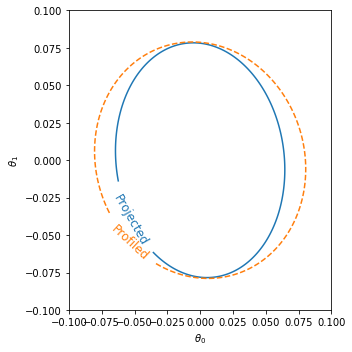

In [57]:
_ = plot_fisher_information_contours_2d(
    [info_proj, info_prof],
    inline_labels=["Projected", "Profiled"],
    xrange=(-0.1,0.1),
    yrange=(-0.1,0.1)
)

For illustration, we can look at just one physics parameter and one nuisance parameter:

In [66]:
info_demo = project_information(info, [0, 4])

info_demo_profiled = np.zeros((2,2))
info_demo_profiled[0,0] = profile_information(info_demo, [0,])

12:06 madminer.fisherinfor DEBUG   Profiling Fisher information


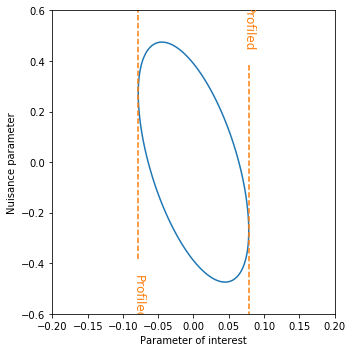

In [71]:
_ = plot_fisher_information_contours_2d(
    [info_demo, info_demo_profiled],
    inline_labels=[None, "Profiled"],
    xrange=(-0.2,0.2),
    yrange=(-0.6,0.6),
    xlabel="Parameter of interest",
    ylabel="Nuisance parameter",
)

In [63]:
plot_fisher_information_contours_2d?